In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch import optim
from torchvision.datasets import CIFAR10,MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [46]:
t=transforms.Compose([  transforms.ToTensor(),
                        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                        ])

In [104]:
train_data=CIFAR10(root=r"./data",train=True,transform=t,download=True)
test_data=CIFAR10(root=r"./data",train=False,transform=t,download=True)
# train_data=MNIST(root=r"./data",train=True,transform=t,download=True)
# test_data=MNIST(root=r"./data",train=False,transform=t,download=True)


Files already downloaded and verified
Files already downloaded and verified


In [112]:
train_loader=DataLoader(train_data,batch_size=128,shuffle=True)
test_loader=DataLoader(test_data,batch_size=128,shuffle=False)

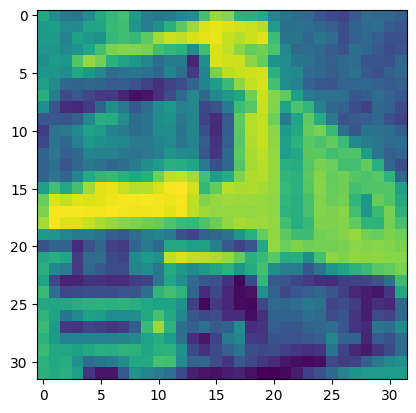

In [106]:
plt.imshow(train_data[1][0][0])
plt.show()

In [146]:
class CIFAR_Module(nn.Module):
    def __init__(self,in_channel):
        self.in_channel=in_channel
        super(CIFAR_Module,self).__init__()
        self.con1=nn.Conv2d(in_channel,6*in_channel,5)
        self.pool1=nn.MaxPool2d(5,stride=2)
        self.con2=nn.Conv2d(6*in_channel,16*in_channel,5)
        self.pool2=nn.MaxPool2d(5,stride=2)
        self.flat=nn.Flatten()
        self.fc1=nn.Linear(192,100*in_channel)
        self.fc2=nn.Linear(100*in_channel,40*in_channel)
        self.fc3=nn.Linear(40*in_channel,10)
    def forward(self,x):
        x=self.con1(x)
        x=f.relu(x)
        x=self.pool1(x)
        x=f.relu(x)
        x=self.con2(x)
        x=f.relu(x)
        x=self.pool2(x)
        x=self.flat(x)
        x=self.fc1(x)
        x=f.relu(x)
        x=self.fc2(x)
        x=f.relu(x)
        x=self.fc3(x)
        return x

In [147]:
model=CIFAR_Module(3)
criterian=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)


In [148]:
summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 28, 28]           1,368
         MaxPool2d-2           [-1, 18, 12, 12]               0
            Conv2d-3             [-1, 48, 8, 8]          21,648
         MaxPool2d-4             [-1, 48, 2, 2]               0
           Flatten-5                  [-1, 192]               0
            Linear-6                  [-1, 300]          57,900
            Linear-7                  [-1, 120]          36,120
            Linear-8                   [-1, 10]           1,210
Total params: 118,246
Trainable params: 118,246
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 0.45
Estimated Total Size (MB): 0.62
----------------------------------------------------------------


In [149]:
print(model)

CIFAR_Module(
  (con1): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con2): Conv2d(18, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=192, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [150]:
num_epoch=10
for epoch in range(num_epoch):
    running_loss=0.0
    for image,label in train_loader:
        output=model(image)
        loss=criterian(output,label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss+=loss.item()
    print(f"epoch[{epoch+1}/{num_epoch}]- loss:{running_loss/len(train_loader)}")

epoch[1/10]- loss:1.7081881807283368
epoch[2/10]- loss:1.3710589085698432
epoch[3/10]- loss:1.220689069736949
epoch[4/10]- loss:1.127970708148254
epoch[5/10]- loss:1.0480759779510596
epoch[6/10]- loss:0.9954065834469807
epoch[7/10]- loss:0.9527413178892696
epoch[8/10]- loss:0.9123077894110814
epoch[9/10]- loss:0.8803341995419749
epoch[10/10]- loss:0.8484138572002615


In [151]:
model.eval()
with torch.no_grad():
    correct=0.0
    total=0.0
    for image,label in test_loader:
        output=model(image)
        _,predicted=torch.max(output,1)
        correct+=(predicted==label).sum().item()
        total+=label.size(0) 
    print(f"accuracy: {(correct/total)*100}")

accuracy: 66.86
